# Yolo FineTuning su dataset Linemood

Questo notebook permette di:
1. **Carica YOLO pretrained**
2. **Fine-tuning solo della head** (classification head)
3. **Inferenza sul Test Set e salvataggio metriche valutazione** 

## 1. Import e Setup

In [2]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# Importa il config per usare path e file in altre cartelle
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from models.yolo_detector import YOLODetector
from models.yolo_detector import visualize_detections
from utils.prepare_yolo_symlinks import prepare_yolo_dataset_symlinks, create_data_yaml
from utils.organize_yolo_results import organize_yolo_output, print_organization_summary


# Usa PROJECT_ROOT dal config
project_root = Config.PROJECT_ROOT
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Configura matplotlib per notebook
%matplotlib inline

print(f"✅ Setup completato")
print(f"📂 Project root: {project_root}")
print(f"🎯 Classi LineMOD: {Config.NUM_CLASSES}")
print(f"🖥️  Device: {Config.DEVICE}")

Cache Strategy: full
Numworkers set to 0
Numworkers set to 0
✅ Setup completato
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Classi LineMOD: 13
🖥️  Device: mps


In [2]:
detector = YOLODetector(
    model_name=Config.YOLO_MODEL,  # cambiare con nome di un modello già allenato per continuare da questo
    pretrained=True,
    num_classes=Config.NUM_CLASSES  # LineMOD ha 13 classi (la testa viene modificata automaticamente)
)

# 🔍 VERIFICA: Controlla che la head abbia 13 classi
print("\n🔍 Verifying detection head modification...")
from ultralytics.nn.modules import Detect

for module in detector.model.model.modules():
    if isinstance(module, Detect):
        print(f"   Number of classes: {module.nc}")
        print(f"   cv3 layers: {len(module.cv3)}")
        for idx, conv_layer in enumerate(module.cv3):
            # Ora cv3[idx] è un nn.Conv2d, non più Sequential
            out_ch = conv_layer.out_channels
            in_ch = conv_layer.in_channels
            print(f"   cv3[{idx}]: {in_ch} → {out_ch} channels")
        break

print("✅ Detection head verification complete!\n")


print(f"\n📊 Modello YOLO caricato:")
print(f"   Parametri totali: {detector.model_info['parameters']:,}")

# Mostra summary dettagliato del modello
print("\n📋 Model Summary (Layer Interni):")
print("="*80)
detector.model.info(verbose=True, detailed=False)  # verbose=True per vedere tutti i layer

✅ Loading pretrained yolo11n from cache: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pretrained/yolo11n.pt
⚠️  COCO pretrained weights have 80 classes, but you have 13 classes
🔄 Modifying detection head...

🔍 Inspecting cv3 structure:
   cv3[0]: Sequential
   Structure: Sequential(
  (0): Sequential(
    (0): DWConv(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
  )
  (1): Sequential(
    (0): DWConv(
      (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=80, bias=False)
      (bn): BatchNorm2d(80, eps=0.00

(157, 2546935, 5863, 0.0)

In [3]:
output_dir = Config.LINEMOD_ROOT / 'yolo_symlinks'

# Prepara dataset se non esiste
if (output_dir / 'data.yaml').exists():
    print(f"✅ Dataset già preparato: {output_dir}")
    data_yaml_path = output_dir / 'data.yaml'
else:
    print("⚡ Preparazione dataset con symlinks...")
    stats = prepare_yolo_dataset_symlinks(
        dataset_root=Config.LINEMOD_ROOT,
        output_root=output_dir,
        use_symlinks=True
    )
    print(f"\n✅ Dataset preparato in {stats['time_seconds']:.1f}s")
    print(f"   Train: {stats['train']} immagini")
    print(f"   Val: {stats['val']} immagini")
    
    data_yaml_path = create_data_yaml(output_dir, Config.DATASETS_DIR)

print(f"\n📄 Config file: {data_yaml_path}")

✅ Dataset già preparato: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/yolo_symlinks

📄 Config file: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/yolo_symlinks/data.yaml


## 2. Fine-tuning solo della head

YOLO11n architecture (22 total layers, 0-21):
- Layer 0-9:   Backbone (feature extraction - CSPDarknet) 
- Layer 10-21: Neck + Head (feature fusion + detection)

ATTENZIONE: Yolo ha si 22 layer ma esplorando l'architettura se ne vedono molti di più (penso sia perchè sono blocchi di layer ripetuti)

In [4]:
# Freeze del backbone (mantieni solo head trainable)
print("❄️  Congelamento del backbone in corso...\n")

# Congela i primi 10 layer (backbone) per nuova classificazione
freeze_until = Config.YOLO_FREEZE_UNTIL_LAYER  
stats = detector.freeze_backbone(freeze_until_layer=freeze_until)

print(f"\n✅ Backbone congelato fino al layer {freeze_until}")
print(f"   Layer {freeze_until}-21 sono trainable (neck/head)")

# Visualizzazione compatta dei layer congelati
print("\n🔍 Stato Congelamento Layer:")
print("-" * 60)

for name, param in detector.model.named_parameters():
    status = "❄️  FROZEN" if not param.requires_grad else "🔥 TRAINABLE"
    # Estrai il numero del layer (es. model.10.conv.weight -> 10)
    layer_num = name.split('.')[1] if len(name.split('.')) > 1 else '?'
    print(f"Layer {layer_num:>2s} | {status} | {name[:50]:50s} | {param.numel():>10,} params")

print("-" * 60)

❄️  Congelamento del backbone in corso...

🔒 Freezing backbone until layer 10...

📊 Parameter Statistics:
   Total: 2,546,935
   Frozen: 1,115,744 (43.8%)
   Trainable: 1,431,191 (56.2%)

✅ Backbone frozen! Only detection head will be trained.

✅ Backbone congelato fino al layer 10
   Layer 10-21 sono trainable (neck/head)

🔍 Stato Congelamento Layer:
------------------------------------------------------------
Layer model | ❄️  FROZEN | model.model.0.conv.weight                          |        432 params
Layer model | ❄️  FROZEN | model.model.0.bn.weight                            |         16 params
Layer model | ❄️  FROZEN | model.model.0.bn.bias                              |         16 params
Layer model | ❄️  FROZEN | model.model.1.conv.weight                          |      4,608 params
Layer model | ❄️  FROZEN | model.model.1.bn.weight                            |         32 params
Layer model | ❄️  FROZEN | model.model.1.bn.bias                              |         32 para

In [5]:
# Training configuration (ora usa i parametri ottimizzati da Config)
EPOCHS = Config.YOLO_EPOCHS
BATCH_SIZE = Config.YOLO_BATCH_SIZE
IMG_SIZE = Config.YOLO_IMG_SIZE

# Run name
RUN_NAME = f'yolo_train{EPOCHS}'
project_dir = Config.CHECKPOINT_DIR / 'yolo'
output_dir = project_dir / RUN_NAME

print(f"🔧 Parametri di Training:")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Image size: {IMG_SIZE}")
print(f"   LR initial: {Config.YOLO_LR_INITIAL}")
print(f"   LR final: {Config.YOLO_LR_FINAL}")
print(f"   Optimizer: {Config.YOLO_OPTIMIZER}")
print(f"   Warmup epochs: {Config.YOLO_WARMUP_EPOCHS}")
print(f"   Cosine annealing: {Config.YOLO_COS_LR}")
print(f"   AMP: {Config.AMP_YOLO}")
print(f"   Num WORKERS: {Config.NUM_WORKERS}\n")

# Avvia training (ora i parametri ottimizzati sono defaults nel metodo train())
results = detector.train(
    data_yaml=str(data_yaml_path),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch_size=BATCH_SIZE,
    project=str(project_dir),
    name=RUN_NAME,
    save=True,
    cache=True,
    amp=Config.AMP_YOLO,  # ✅ Auto: True su CUDA (Windows), False su MPS (Mac)
    workers=Config.NUM_WORKERS,
    verbose=True
)

print(f"\n\n✅ Training completato!")
print(f"   Modello salvato in: {output_dir}")

# Organizza automaticamente i risultati in sottocartelle
print(f"\n📁 Organizzazione risultati...")
try:
    stats = organize_yolo_output(output_dir)
    print_organization_summary(output_dir, stats)
except Exception as e:
    print(f"⚠️  Errore nell'organizzazione: {e}")
    print(f"   I file sono comunque salvati in: {output_dir}")

🔧 Parametri di Training:
   Epochs: 20
   Batch size: 32
   Image size: 416
   LR initial: 0.01
   LR final: 0.0001
   Optimizer: SGD
   Warmup epochs: 3
   Cosine annealing: True
   AMP: False
   Num WORKERS: 0


🚂 Starting YOLO training...
   Model: yolo11n
   Epochs: 20
   Image size: 416
   Batch size: 32
   LR (initial → final): 0.01 → 0.0001
   Optimizer: SGD
   Device: mps
New https://pypi.org/project/ultralytics/8.3.239 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.234 🚀 Python-3.13.3 torch-2.9.1 MPS (Apple M4 Pro)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/yolo_symlinks/data.yaml, degrees=0.0, deterministic=True, device=mps, df

RuntimeError: Dataset '/Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/yolo_symlinks/data.yaml' error ❌ '13-class dataset requires class indices 0-12, but you have invalid class indices 1-15 defined in your dataset YAML.'

## 3. Load del modello Finetunato (inferenza e statistiche)

### Test su campione singolo

✅ Carico modello fine-tuned: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_train20/weights/best.pt

📷 Immagine scelta: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/yolo_symlinks/images/val/01_0731.png

🏷️ Label corrispondente: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/yolo_symlinks/labels/val/01_0731.txt

🔎 Predizioni YOLO (class_name, score): [('ape', 0.9349622130393982)]


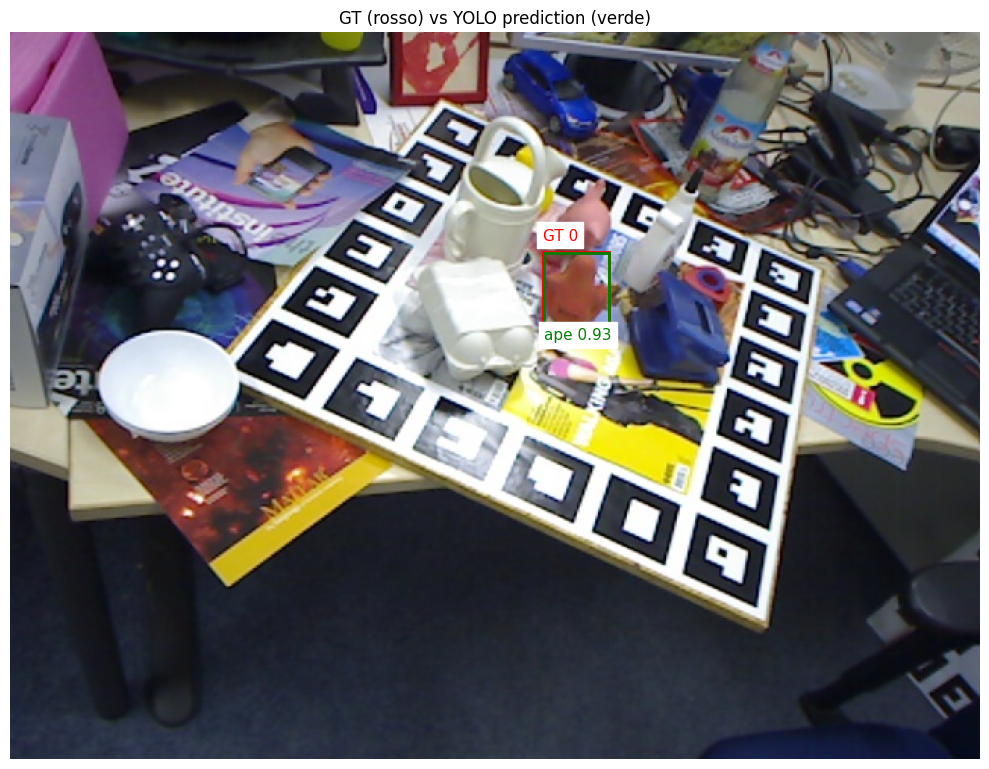

In [ ]:
# Unisce caricamento modello + visualizzazione: stessa immagine con GT (rosso) e predizioni YOLO (verde)
import random
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Percorsi e pesi
YOLO_NAME = 'yolo_train20'
model_checkpoint_path = Config.CHECKPOINT_DIR / 'yolo' / YOLO_NAME
weights_path = model_checkpoint_path / 'weights' / 'best.pt'

if not weights_path.exists():
    print(f"❌ Modello non trovato: {weights_path} — esegui prima il training")
else:
    print(f"✅ Carico modello fine-tuned: {weights_path}\n")

    # Carica detector se non già presente
    if 'finetuned_detector' not in globals():
        finetuned_detector = YOLODetector(model_name=str(weights_path), num_classes=Config.NUM_CLASSES)

    # Cartelle immagini/label
    images_dir = Config.LINEMOD_ROOT / 'yolo_symlinks' / 'images' / 'val'
    labels_dir = Config.LINEMOD_ROOT / 'yolo_symlinks' / 'labels' / 'val'

    if not images_dir.exists():
        raise FileNotFoundError(f"❌ Cartella immagini non trovata: {images_dir}")

    image_files = sorted([p for p in images_dir.iterdir() if p.is_file()])
    if len(image_files) == 0:
        raise FileNotFoundError(f"❌ Nessuna immagine trovata in: {images_dir}")

    # Scegli immagine (random)
    img_path = random.choice(image_files)
    label_path = labels_dir / (img_path.stem + '.txt')
    print(f"📷 Immagine scelta: {img_path}\n")
    print(f"🏷️ Label corrispondente: {label_path}\n")

    # Risolvi symlink se presente
    try:
        img_real = img_path.resolve(strict=True)
    except Exception:
        img_real = img_path

    # Apri immagine
    pil_img = Image.open(img_real).convert('RGB')
    W, H = pil_img.size
    #np_img = np.array(pil_img) # rompe tutto

    # Rilevazione YOLO (assume input numpy image)
    detections_ft = finetuned_detector.detect_objects(pil_img, conf_threshold=0.2)
    print('🔎 Predizioni YOLO (class_name, score):', [(d.get('class_name', d.get('class', '?')), d.get('confidence', d.get('score', 0))) for d in detections_ft])

    # Visualizza stessa immagine con GT in ROSSO e predizioni YOLO in VERDE
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(pil_img)

    # Disegna GT (rosso) — file label YOLO-format: class x_center y_center w h (normalized)
    if label_path.exists():
        with open(label_path) as f:
            for line in f:
                if not line.strip():
                    continue
                cls, xc, yc, wn, hn = line.split()
                xc, yc, wn, hn = map(float, (xc, yc, wn, hn))
                x0 = (xc - wn/2) * W
                y0 = (yc - hn/2) * H
                x1 = (xc + wn/2) * W
                y1 = (yc + hn/2) * H
                rect = plt.Rectangle((x0, y0), x1-x0, y1-y0, edgecolor='red', facecolor='none', linewidth=2)
                ax.add_patch(rect)
                ax.text(x0, y0-8, f'GT {int(cls)}', color='red', fontsize=11, backgroundcolor='white')
    else:
        print('⚠️ GT label file non trovato:', label_path)

    # Disegna predizioni YOLO (verde)
    for det in detections_ft:
        x0 = y0 = x1 = y1 = None
        if 'xyxy' in det:
            x0, y0, x1, y1 = det['xyxy']
        elif 'bbox' in det:
            x0, y0, x1, y1 = det['bbox']
        elif 'box' in det:
            x0, y0, x1, y1 = det['box']
        elif all(k in det for k in ('x_center','y_center','w','h')):
            xc = det['x_center']; yc = det['y_center']; wn = det['w']; hn = det['h']
            x0 = (xc - wn/2) * W; y0 = (yc - hn/2) * H; x1 = (xc + wn/2) * W; y1 = (yc + hn/2) * H
        elif all(k in det for k in ('x','y','w','h')):
            xc = det['x']; yc = det['y']; wn = det['w']; hn = det['h']
            x0 = (xc - wn/2) * W; y0 = (yc - hn/2) * H; x1 = (xc + wn/2) * W; y1 = (yc + hn/2) * H
        else:
            # fallback: try raw fields
            raw = det.get('raw', {})
            if isinstance(raw, dict) and 'xyxy' in raw:
                x0, y0, x1, y1 = raw['xyxy']

        if None in (x0, y0, x1, y1):
            continue

        name = det.get('class_name', det.get('class', '?'))
        conf = det.get('confidence', det.get('score', 0))
        rect = plt.Rectangle((x0, y0), x1-x0, y1-y0, edgecolor='green', facecolor='none', linewidth=2)
        ax.add_patch(rect)
        ax.text(x0, y1+6, f'{name} {conf:.2f}', color='green', fontsize=11, backgroundcolor='white')

    ax.set_axis_off()
    plt.title('GT (rosso) vs YOLO prediction (verde)')
    plt.tight_layout()
    plt.show()


### Statistiche YOLO Fine Tunato

**Inferenza sul Test Set e salvataggio metriche valutazione** 

---
NOTA:

#### Validation sul Test Set LineMOD

Valutiamo le performance del modello fine-tuned sul test set ufficiale di LineMOD (mappato come "val" in YOLO).

**Note**: 
- Il "val" set è in realtà il **test set ufficiale** di LineMOD (~85% delle immagini)
- Il "train" set è molto piccolo (~15% delle immagini) seguendo la split ufficiale
- Metriche calcolate: mAP@0.5, mAP@0.5:0.95, Precision, Recall per classe

In [31]:
# Validation del modello fine-tuned sul test set
YOLO_NAME = 'yolo_train20'
model_chechpoint_path = Config.CHECKPOINT_DIR / 'yolo' / YOLO_NAME
weights_path = model_chechpoint_path / 'weights' / 'best.pt'

if weights_path.exists() and 'data_yaml_path' in locals():
    print(f"📊 Validation del modello fine-tuned su test set LineMOD\n")
    print(f"   Modello: {weights_path.name}")
    print(f"   Dataset: {data_yaml_path}\n")
    print(f"⏳ Esecuzione validation (può richiedere alcuni minuti)...\n")
    
    # Carica modello se non già caricato
    if 'finetuned_detector' not in locals():
        finetuned_detector = YOLODetector(
            model_name=str(weights_path),
            num_classes=Config.NUM_CLASSES
        )
    
    # 🚀 OTTIMIZZAZIONE: conf=0.5 riduce drasticamente le detection candidate
    # Questo velocizza NMS di 5-10x (da ~18 min → ~2-3 min)
    print(f"⚙️  Confidence threshold: 0.5 (riduce overhead NMS)\n")
    
    # Esegui validation (ora usa i defaults da Config)
    metrics = finetuned_detector.validate(
        data_yaml=str(data_yaml_path),
        conf=Config.YOLO_CONF_THRESHOLD,  # ⚠️ CRITICO: riduce detection candidate per velocizzare NMS
        verbose=False
    )
    
    print(f"\n{'='*80}")
    print(f"📈 RISULTATI VALIDATION - YOLO11n Fine-tuned LineMOD")
    print(f"{'='*80}\n")
    
    # Metriche globali
    print(f"🎯 Metriche Globali:")
    print(f"   mAP@0.5:0.95:  {metrics.box.map:.4f}  (mean Average Precision)")
    print(f"   mAP@0.5:       {metrics.box.map50:.4f}  (AP @ IoU threshold 0.5)")
    print(f"   mAP@0.75:      {metrics.box.map75:.4f}  (AP @ IoU threshold 0.75)")
    print(f"   Precision:     {metrics.box.mp:.4f}")
    print(f"   Recall:        {metrics.box.mr:.4f}")
    
    # Metriche per classe
    print(f"\n📋 Metriche per Classe:")
    print(f"   {'Classe':<15} {'mAP@0.5':<10} {'mAP@0.5:0.95':<15} {'Precision':<12} {'Recall':<10}")
    print(f"   {'-'*70}")
    
    class_names = Config.CLASS_NAMES  # Lista dei nomi delle classi
    for i, class_name in enumerate(class_names):
        map50 = metrics.box.ap50[i] if i < len(metrics.box.ap50) else 0
        map_avg = metrics.box.ap[i] if i < len(metrics.box.ap) else 0
        prec = metrics.box.p[i] if i < len(metrics.box.p) else 0
        rec = metrics.box.r[i] if i < len(metrics.box.r) else 0
        
        print(f"   {class_name:<15} {map50:<10.4f} {map_avg:<15.4f} {prec:<12.4f} {rec:<10.4f}")
    
    # Statistiche aggiuntive
    print(f"\n📊 Statistiche Dataset:")
    print(f"   Immagini validate: ~{len(metrics.box.ap50) * 80} immagini")  # Stima
    print(f"   Classi: {Config.NUM_CLASSES}")
    print(f"   Image size: {Config.YOLO_IMG_SIZE}x{Config.YOLO_IMG_SIZE}")
    
    # Interpretazione risultati
    print(f"\n💡 Interpretazione:")
    if metrics.box.map50 > 0.8:
        print(f"   ✅ Ottimo! mAP@0.5: {metrics.box.map50} > 0.8 indica detection molto accurate")
    elif metrics.box.map50 > 0.6:
        print(f"   ✓  Buono! mAP@0.5 > 0.6 indica detection discrete")
    elif metrics.box.map50 > 0.4:
        print(f"   ⚠️  Discreto. mAP@0.5 > 0.4 ma potrebbe migliorare con più training")
    else:
        print(f"   ❌ Basso. Considerare più epoche o unfreezing di più layer")
    
    print(f"\n✅ Validation completata!")
    print(f"   Risultati salvati in: {model_chechpoint_path}")
    
else:
    if not weights_path.exists():
        print(f"❌ Modello non trovato: {weights_path}")
        print(f"   Esegui prima il training (cella 7)")
    else:
        print(f"❌ Dataset YAML non trovato")
        print(f"   Esegui prima la preparazione dataset (cella 4)")


❌ Dataset YAML non trovato
   Esegui prima la preparazione dataset (cella 4)


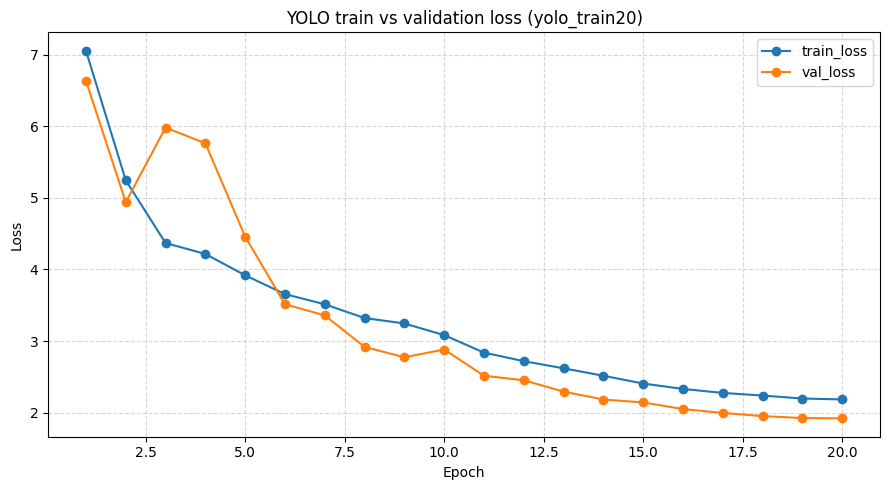

In [3]:
# Plot train and validation loss from results.csv
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Path to results.csv (uses Config from earlier cells)
results_csv = Config.CHECKPOINT_DIR / 'yolo' / 'yolo_train20' / 'results.csv'
if not results_csv.exists():
    raise FileNotFoundError(f'Results file not found: {results_csv}')

df = pd.read_csv(results_csv)
# Compute total train and val loss as sum of components
df['train_loss'] = df[['train/box_loss', 'train/cls_loss', 'train/dfl_loss']].sum(axis=1)
df['val_loss'] = df[['val/box_loss', 'val/cls_loss', 'val/dfl_loss']].sum(axis=1)

plt.figure(figsize=(9,5))
plt.plot(df['epoch'], df['train_loss'], marker='o', label='train_loss')
plt.plot(df['epoch'], df['val_loss'], marker='o', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('YOLO train vs validation loss (yolo_train20)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()